# Load

In [ ]:
%%capture
import numpy as np
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import csv
import os
import missingno as msno
from collections import Counter
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import defaultdict
import statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import preprocessing
import plotly.express as px
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Finding Similar Costumers

## 1.1 Set up the data

First, we load the dataset

In [ ]:
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/bank_transactions.csv')

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


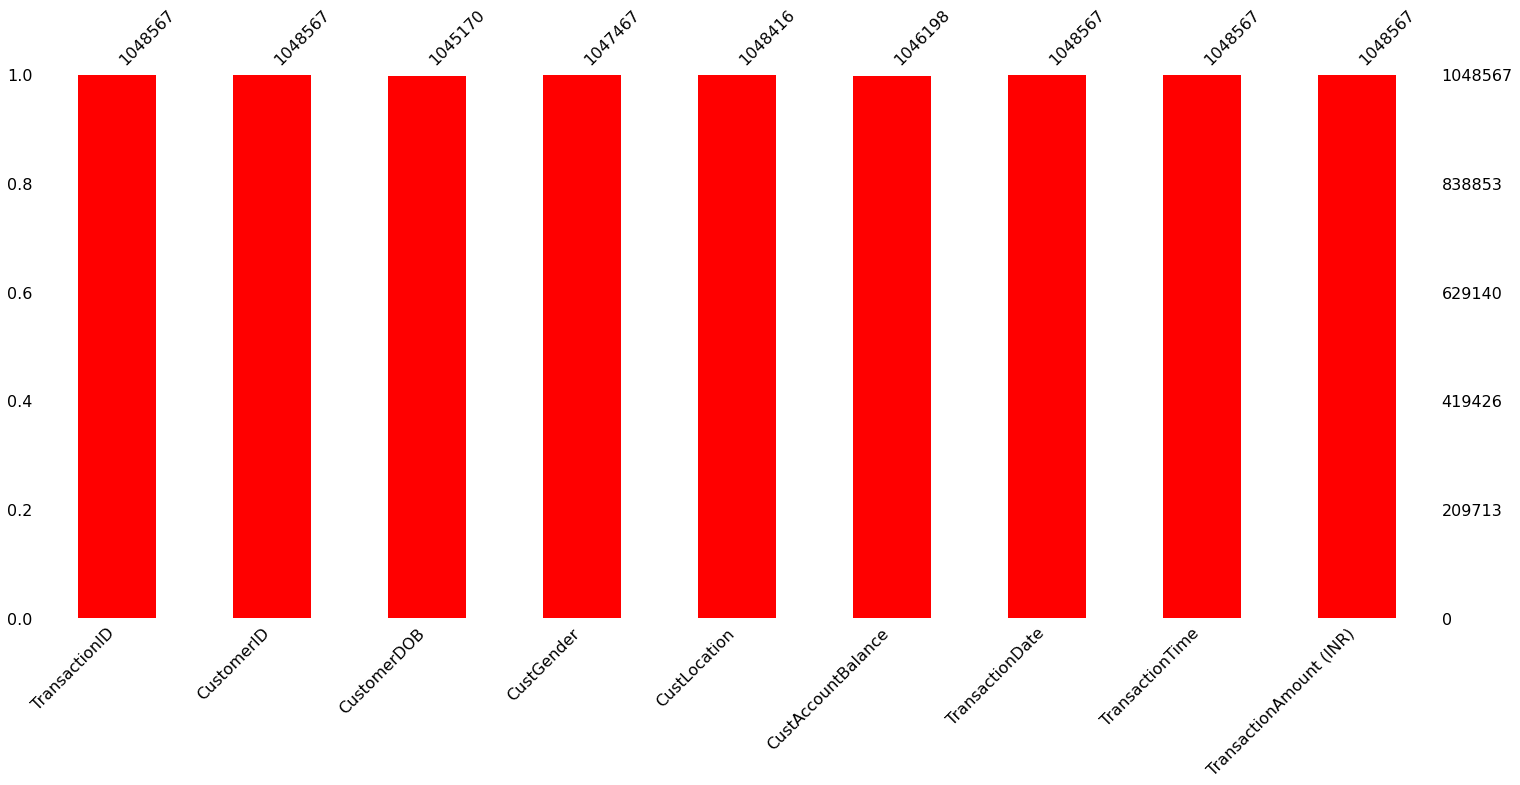

In [ ]:
msno.bar(df_bank, color='red')

In [ ]:
#drop nas
df_bank.dropna(inplace=True) 

# change format of the date
df_bank.CustomerDOB = pd.to_datetime(df_bank.CustomerDOB)
df_bank.loc[df_bank['CustomerDOB'].dt.year >= 2022, ['CustomerDOB']] -= pd.DateOffset(years = 100)

# change format of TransactionDate
df_bank['TransactionDate'] = pd.to_datetime(df_bank['TransactionDate'])

# change format of TransactionTime
df_bank.TransactionTime = df_bank.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())

#drop year = 1800
df_bank.drop(df_bank[df_bank.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [ ]:
# change the type of TransactionAmount (INR)
df_bank['TransactionAmount (INR)'] = df_bank['TransactionAmount (INR)'].astype(int)

In [ ]:
# we notice that there is row in which a gender is equal to T, so we decided to drop it
df_bank.drop(df_bank[df_bank['CustGender'].isin(['T'])].index,axis=0,inplace=True)

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762


In [ ]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 107.4+ MB


We decided to store the cleaned dataset in our drive folder to avoid the clean procedure again

In [ ]:
df_bank.to_csv('/content/drive/MyDrive/adm hw4/df_cleaned.csv', index=False)

In [ ]:
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_cleaned.csv')

We create the Age column 

In [ ]:
df_bank.CustomerDOB = pd.to_datetime(df_bank.CustomerDOB)
df_bank['CustomerAge'] = (( pd.to_datetime('today') - df_bank.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
df_bank['CustomerAge'] = df_bank['CustomerAge'].astype(int)

To handle the multiple operations for each custumer ID, we select the mode for the variables regarding the gender and age, instead for  Balance and Transaction amount we use the mean.

In [ ]:
# Mean for Transaction
trans = df_bank[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Avg'}, inplace = True)
df_bank = df_bank.merge(right = trans, on = 'CustomerID')

# Mean for Balance
bal = df_bank[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
bal = bal.drop(columns = 'index')
bal.rename(columns = {'CustAccountBalance' : 'Balance_Avg'}, inplace = True)
df_bank = df_bank.merge(right = bal, on = 'CustomerID')

# Mode for Gender                                                                                                    #if we have two mode, we take the first
g=df_bank[['CustomerID', 'CustGender']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustGender'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() 
g = g.drop(columns = 'index')
g.rename(columns = {'CustGender' : 'Gender_Mode'}, inplace = True)
df_bank = df_bank.merge(right = g, on = 'CustomerID')

# Mode for Age                                                                                                       #if we have two mode, we take the first
ag = df_bank[['CustomerID', 'CustomerAge']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustomerAge'].agg( lambda x: pd.Series.mode(x)[0]).reset_index()
ag = ag.drop(columns = 'index')
ag.rename(columns = {'CustomerAge' : 'Age_Mode'}, inplace = True)
df_bank = df_bank.merge(right = ag, on = 'CustomerID')

In [ ]:
df_bank[['CustomerID','Age_Mode','Gender_Mode','Balance_Avg','Transaction_Avg']].nunique()

CustomerID         839081
Age_Mode               97
Gender_Mode             2
Balance_Avg        264602
Transaction_Avg     27569
dtype: int64

Execpt for `Gender_Mode`, the other variables have too many unique values, we have to divide them into classes, so we create:




####1.   `Balance_class`



In [ ]:
df_bank['Balance_class'] = pd.cut(x=df_bank['Balance_Avg'], bins=[min(df_bank['Balance_Avg'])-1, 1000, 5000, 12000,
                                          30000, 120000,max(df_bank['Balance_Avg'])+1])

In [ ]:
df_bank['Balance_class'].value_counts()

(30000.0, 120000.0]        241800
(12000.0, 30000.0]         216439
(5000.0, 12000.0]          165918
(120000.0, 115035496.1]    145669
(1000.0, 5000.0]           119677
(-1.0, 1000.0]              95819
Name: Balance_class, dtype: int64

####2.  `Transaction_class`

In [ ]:
df_bank['Transaction_class']=pd.cut(x=df_bank['Transaction_Avg'], bins=[min(df_bank['Transaction_Avg'])-1,500,1500,
                                          7000, 12000,max(df_bank['Transaction_Avg'])+1])

In [ ]:
df_bank['Transaction_class'].value_counts()

(-1.0, 500.0]           508892
(500.0, 1500.0]         278648
(1500.0, 7000.0]        167092
(12000.0, 1560035.0]     15403
(7000.0, 12000.0]        15287
Name: Transaction_class, dtype: int64

####3. `Generation`





In [ ]:
df_bank['Generation']=pd.cut(x=df_bank['Age_Mode'], bins=[min(df_bank['Age_Mode'])-1,18,30,
                                          50, 75,max(df_bank['Age_Mode'])+1])

In [ ]:
df_bank['Generation'].value_counts()

(30, 50]     710679
(18, 30]     215530
(50, 75]      55798
(75, 101]      2920
(1, 18]         395
Name: Generation, dtype: int64

Now that we are done with systemizing the data, let's select only the columns that we think are interesting for our purposes

In [ ]:
selected_cols=['CustomerID', 'Generation', 'Transaction_class', 'Balance_class', 'Gender_Mode']

In [ ]:
d=df_bank[selected_cols]
d.drop_duplicates(inplace=True)
d.drop('CustomerID', inplace=True, axis=1)
d

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Generation,Transaction_class,Balance_class,Gender_Mode
0,"(18, 30]","(-1.0, 500.0]","(12000.0, 30000.0]",F
1,"(50, 75]","(12000.0, 1560035.0]","(1000.0, 5000.0]",M
2,"(18, 30]","(-1.0, 500.0]","(12000.0, 30000.0]",F
3,"(30, 50]","(500.0, 1500.0]","(120000.0, 115035496.1]",F
5,"(30, 50]","(1500.0, 7000.0]","(5000.0, 12000.0]",F
...,...,...,...,...
985317,"(30, 50]","(1500.0, 7000.0]","(-1.0, 1000.0]",M
985318,"(18, 30]","(500.0, 1500.0]","(1000.0, 5000.0]",M
985319,"(30, 50]","(500.0, 1500.0]","(5000.0, 12000.0]",M
985320,"(30, 50]","(-1.0, 500.0]","(12000.0, 30000.0]",M


In [ ]:
d.to_csv('/content/drive/MyDrive/adm hw4/df_for1_2.csv', index=False)

In [ ]:
d.isnull().sum()

Generation           0
Transaction_class    0
Balance_class        0
Gender_Mode          0
dtype: int64

## 1.2 Fingerprint hashing

In [ ]:
df1 = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_for1_2.csv')

We change the labels

In [ ]:
cleanup = {"Generation":     {"(1, 18]": '1',"(18, 30]": '2', "(30, 50]": '3',
                              "(50, 75]": '4',"(75, 101]": '5',},
           "Transaction_class": {"(-1.0, 500.0]": '1', "(500.0, 1500.0]": '2', "(1500.0, 7000.0]": '3', "(7000.0, 12000.0]": '4',
                                  "(12000.0, 1560035.0]": '5' },
           "Balance_class": {"(-1.0, 1000.0]": '1', "(1000.0, 5000.0]": '2', "(5000.0, 12000.0]": '3', "(12000.0, 30000.0]": '4',
                                  "(30000.0, 120000.0]": '5' , "(120000.0, 115035496.1]" : '6'}}

In [ ]:
df1 = df1.replace(cleanup)
df1.head()

,Generation,Transaction_class,Balance_class,Gender_Mode
0,2,1,4,F
1,4,5,2,M
2,2,1,4,F
3,3,2,6,F
4,3,3,3,F


We need the set of all possible outcomes to create the index matrix

In [ ]:
Genders=set(df1.Gender_Mode)
Generations=set(df1.Generation)
Balances=set(df1.Balance_class)
Transactions=set(df1.Transaction_class)

Then we turn them into lists

In [ ]:
genders=list(Genders)
generations=list(Generations)
balances=list(Balances)
transactions=list(Transactions)

In [ ]:
def MapToZerOne(attr, n_col,df):
  n=len(attr)
  column=df[df.columns[n_col]]
  z= np.zeros(len(column))
  for i in range(0,n):
   temp= np.array([1 if x in attr[i] else 0 for x in np.array(column)])
   h= np.vstack((z, temp))
   z=h
  final=h[1:]
  return final

In [ ]:
def get_Matrix(df):
  n_cols=len(df.columns)
  l= len(df[df.columns[1]])
  init=np.zeros(l)
  for j in range(0,n_cols):
    attr=set(df[df.columns[j]])
    attr=list(attr)
    tempr=MapToZerOne(attr,j,df)
    hr= np.vstack((init, tempr))
    init=hr
  final2=hr[1:]
  return final2

In [ ]:
matrix_onehot=get_Matrix(df1)
matrix_onehot

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [ ]:
len(matrix_onehot) == len(genders)+len(generations)+len(balances)+len(transactions)

True

So the dimensioins match, we have a vector for each class of our shingles

In [ ]:
def hashing(matr,df):
  

#2 Grouping customers together!

## 2.1 Getting your data + feature engineering


First, we load the  cleaned dataset in point 1.1

In [ ]:
# first we load the df
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_cleaned.csv')

Now we define the seven new features proposed in the homework:

In [ ]:
#1 Number of transactions
temp = df_bank[['CustomerID', 'TransactionID']].groupby(by = 'CustomerID', as_index = False, sort = False).count().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionID' : 'Transaction_Frequency'}, inplace = True)
df_bank = df_bank.merge(right = temp, on = 'CustomerID')


#2 Number of transactions with a balance bigger than 100 USD
bigger_100=df_bank['TransactionAmount (INR)'].apply(lambda x: x>=100)
bigger_100=bigger_100*1
df_bank.insert(10,"Bigger100",bigger_100)
big = df_bank[['CustomerID', 'Bigger100']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger100' : 'Number_Bigger_100'}, inplace = True)
df_bank = df_bank.merge(right = big, on = 'CustomerID')


#3 Average amount of the transactions
trans = df_bank[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Avg'}, inplace = True)
df_bank = df_bank.merge(right = trans, on = 'CustomerID')


#4 Average balance
bal = df_bank[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
bal = bal.drop(columns = 'index')
bal.rename(columns = {'CustAccountBalance' : 'Balance_Avg'}, inplace = True)
df_bank = df_bank.merge(right = bal, on = 'CustomerID')


#5 Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
df_bank['Utilisation_0'] = df_bank['CustAccountBalance'] - df_bank['TransactionAmount (INR)']
t = df_bank[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Avg'}, inplace = True)
df_bank = df_bank.merge(right = t, on = 'CustomerID')


#6 Most common gender of the customer
g=df_bank[['CustomerID', 'CustGender']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustGender'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() #if we have two mode, we take the first
g = g.drop(columns = 'index')
g.rename(columns = {'CustGender' : 'Gender_Mode'}, inplace = True)
df_bank = df_bank.merge(right = g, on = 'CustomerID')


#7 Most frequent location of the customer
z=df_bank[['CustomerID', 'CustLocation']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustLocation'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() #if we have two mode, we take the first
z = z.drop(columns = 'index')
z.rename(columns = {'CustLocation' : 'Location_Mode'}, inplace = True)
df_bank = df_bank.merge(right = z, on = 'CustomerID')

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction_Frequency,Bigger100,Number_Bigger_100,Transaction_Avg,Balance_Avg,Utilisation_0,Utilisation_Avg,Gender_Mode,Location_Mode
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25,1,0,0,25.0,17819.050,17794.05,17794.050,F,JAMSHEDPUR
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999,1,1,1,27999.0,2270.690,-25728.31,-25728.310,M,JHAJJAR
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459,1,1,1,459.0,17874.440,17415.44,17415.440,F,MUMBAI
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060,2,1,2,1469.0,434849.495,864443.21,433380.495,F,MUMBAI
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,19:41:48,878,2,1,2,1469.0,434849.495,2317.78,433380.495,F,MUMBAI


So, now we finally have the dataset with the 7 features requested.

We decided to store the dataset in our drive folder to avoid the procedure again

In [ ]:
df_bank.to_csv('/content/drive/MyDrive/adm hw4/df7.csv', index=False)

In order not to stress the ram too much, we delete the dataset from the memory

In [ ]:
del df_bank

In [ ]:
df7 = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df7.csv')

The next step is to add at least 20 new features in the dataset

In [ ]:
def generations(age):
    """
    
    """
    if age=='1800-01-01 00:00:00' or age is np.nan:
        return 'Missing'
    if int(age) in [i for i in range(10,23)]: #we are now assuming that there are not people born before 1922 
        return 'Gen Alpha'
    elif int(age) in [i for i in range(23,46)]:
        return 'Silent Gen'
    elif int(age) in [i for i in range(46,65)]:
        return 'Boomers'
    elif int(age) in [i for i in range(65,81)]:
        return 'Gen X'
    elif int(age) in [i for i in range(81,97)]:
        return 'Gen Y'
    else: # %y goes from 00 to 99 so we only miss the range 1997-2010 (i.e. Gen Z)
        return 'Gen Z'

In [ ]:
#8 Debt for each Custumer ID
debt=df7['Utilisation_Avg'].apply(lambda x: x<0) #if they did, on average, transactions bigger than their balance
debt=debt*1
df7['Debt']=debt

#9 Percentile of Balance_Avg for each Custumer ID
df7['Balance_Avg_Percentile'] = df7.Balance_Avg.rank(pct = True)

#10 Percentile of Utilisation_Avg for each Custumer ID
df7['Utilisation_Avg_Percentile'] = df7.Utilisation_Avg.rank(pct = True)

#11 Average Age for each Custumer ID
df7.CustomerDOB = pd.to_datetime(df7.CustomerDOB)
df7['CustomerAge'] = (( pd.to_datetime('today') - df7.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
df7['CustomerAge'] = df7['CustomerAge'].astype(int)
trans = df7[['CustomerID', 'CustomerAge']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'CustomerAge' : 'Avg_customerAge'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')

#12  Averange Generations for each Custumer ID
gen=df7['Avg_customerAge'].apply(lambda x: generations(x))
df7['Generation']=gen

#13 Sum Transactions for each Custumer ID
trans = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Sum'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')

#14 Standard deviation of Transaction for each Custumer ID
trans = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).std().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Std'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')
df7['Transaction_Std'] = df7['Transaction_Std'].fillna(0)

#15 Month of transaction
df7['TransactionDate'] = pd.to_datetime(df7['TransactionDate'])
df7['TransactionMonth'] = df7['TransactionDate'].dt.month

#16 percentage of balance in transaction in average (transaction/balance)
df7['Transaction_percent_Avg']= df7['Transaction_Avg']/df7['Balance_Avg']

#17 Number of transactions with a balance bigger than 500 USD
bigger_500=df7['TransactionAmount (INR)'].apply(lambda x: x>=500)
bigger_500=bigger_500*1
df7.insert(10,"Bigger500",bigger_500)
big = df7[['CustomerID', 'Bigger500']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger500' : 'Number_Bigger_500'}, inplace = True)
df7 = df7.merge(right = big, on = 'CustomerID')

#18 Number of transactions with a balance bigger than 10000 USD
bigger_10000=df7['TransactionAmount (INR)'].apply(lambda x: x>=10000)
bigger_10000=bigger_10000*1
df7.insert(10,"Bigger10000",bigger_10000)
big = df7[['CustomerID', 'Bigger10000']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger10000' : 'Number_Bigger_10000'}, inplace = True)
df7 = df7.merge(right = big, on = 'CustomerID')

#19 Percentile of Age for each Custumer ID
df7['Avg_customerAge_Percentile'] = df7.Avg_customerAge.rank(pct = True)

#20 Max Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Max'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#21 Min Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Min'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#22 Max Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Max'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#23 Min Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Min'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#24 Median Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustAccountBalance'].median().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Median'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#25 Median Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False)['TransactionAmount (INR)'].median().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Median'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#26 Min Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Min'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')

#27 Max Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Max'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')

#28 Median Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False)['Utilisation_0'].median().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Median'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')


In [ ]:
df7.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction_Frequency,...,Avg_customerAge_Percentile,Transaction_Max,Transaction_Min,Balance_Max,Balance_Min,Balance_Median,Transaction_Median,Utilisation_Min,Utilisation_Max,Utilisation_Median
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25,1,...,0.038752,25,25,17819.05,17819.05,17819.050,25.0,17794.05,17794.05,17794.050
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999,1,...,0.988022,27999,27999,2270.69,2270.69,2270.690,27999.0,-25728.31,-25728.31,-25728.310
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459,1,...,0.009375,459,459,17874.44,17874.44,17874.440,459.0,17415.44,17415.44,17415.440
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060,2,...,0.886613,2060,878,866503.21,3195.78,434849.495,1469.0,2317.78,864443.21,433380.495
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,19:41:48,878,2,...,0.886613,2060,878,866503.21,3195.78,434849.495,1469.0,2317.78,864443.21,433380.495


During the procedures, some extra columns were created and now it is time to remove them

In [ ]:
colstoremove=['Bigger100',
 'Bigger10000',
 'Bigger500',
 'CustAccountBalance',
 'CustGender',
 'CustLocation',
 'CustomerAge',
 'CustomerDOB',
 'TransactionAmount (INR)',
 'TransactionDate',
 'TransactionID',
 'TransactionMonth',
 'TransactionTime',
 'Utilisation_0']

In [ ]:
def removeColList(df,colstoremove):
  """
  """
  my_cols = set(df.columns)
  for i in colstoremove:
   my_cols.remove(i)
  my_cols = list(my_cols)
  Final_df = df[my_cols]
  return Final_df


In [ ]:
Final_df = removeColList(df7,colstoremove)

In [ ]:
Final_df.head()

,Utilisation_Max,Utilisation_Min,Balance_Max,Utilisation_Median,Avg_customerAge,Transaction_Median,Location_Mode,Avg_customerAge_Percentile,Transaction_Sum,Gender_Mode,...,Transaction_Max,Balance_Avg,Transaction_Frequency,Number_Bigger_10000,Utilisation_Avg,Utilisation_Avg_Percentile,Balance_Median,Transaction_percent_Avg,Generation,Number_Bigger_100
0,17794.05,17794.05,17819.05,17794.050,28.0,25.0,JAMSHEDPUR,0.038752,25,F,...,25,17819.050,1,0,17794.050,0.495681,17819.050,0.001403,Silent Gen,0
1,-25728.31,-25728.31,2270.69,-25728.310,66.0,27999.0,JHAJJAR,0.988022,27999,M,...,27999,2270.690,1,1,-25728.310,0.000902,2270.690,12.330613,Gen X,1
2,17415.44,17415.44,17874.44,17415.440,26.0,459.0,MUMBAI,0.009375,459,F,...,459,17874.440,1,0,17415.440,0.490606,17874.440,0.025679,Silent Gen,1
3,864443.21,2317.78,866503.21,433380.495,46.5,1469.0,MUMBAI,0.886613,2938,F,...,2060,434849.495,2,0,433380.495,0.957365,434849.495,0.003378,Boomers,2
4,864443.21,2317.78,866503.21,433380.495,46.5,1469.0,MUMBAI,0.886613,2938,F,...,2060,434849.495,2,0,433380.495,0.957365,434849.495,0.003378,Boomers,2


We stored the final Dataset in our drive

In [ ]:
Final_df.to_csv('/content/drive/MyDrive/adm hw4/Final_df.csv', index=False)

In [ ]:
del Final_df

## 2.2 Choose your features (variables)!

In [ ]:
Fd = pd.read_csv(r'/content/drive/MyDrive/adm hw4/Final_df.csv')


In [ ]:
Fd.drop_duplicates(inplace=True)
Fd.dropna(inplace=True)

In [ ]:
Fd.set_index('CustomerID',inplace=True)

In [ ]:
Fd.columns

Index(['Utilisation_Max', 'Gender_Mode', 'Balance_Median',
       'Utilisation_Avg_Percentile', 'Avg_customerAge_Percentile',
       'Avg_customerAge', 'Balance_Max', 'Number_Bigger_500', 'Balance_Min',
       'Utilisation_Median', 'Transaction_Frequency', 'Balance_Avg_Percentile',
       'Debt', 'Transaction_percent_Avg', 'Generation', 'Utilisation_Avg',
       'Transaction_Min', 'Number_Bigger_10000', 'Transaction_Sum',
       'Transaction_Median', 'Number_Bigger_100', 'Balance_Avg',
       'Transaction_Max', 'Transaction_Std', 'Transaction_Avg',
       'Location_Mode', 'Utilisation_Min'],
      dtype='object')

In [ ]:
cols_to_norm = ['Utilisation_Max',  'Balance_Median',
       'Avg_customerAge', 'Balance_Max', 'Number_Bigger_500', 'Balance_Min',
       'Utilisation_Median', 'Transaction_Frequency',
       'Debt', 'Utilisation_Avg', 'Transaction_Min',
       'Number_Bigger_10000', 'Transaction_Sum', 'Transaction_Median',
       'Number_Bigger_100', 'Balance_Avg', 'Transaction_Max',
       'Transaction_Avg', 'Utilisation_Min','Utilisation_Avg_Percentile','Utilisation_Avg_Percentile', 'Balance_Avg_Percentile','Transaction_Std']

In [ ]:
Fds=StandardScaler().fit_transform(Fd[cols_to_norm].to_numpy())

In [ ]:
Fds = pd.DataFrame(Fds, columns=cols_to_norm)
Fds

,Utilisation_Max,Balance_Median,Avg_customerAge,Balance_Max,Number_Bigger_500,Balance_Min,Utilisation_Median,Transaction_Frequency,Debt,Utilisation_Avg,...,Transaction_Median,Number_Bigger_100,Balance_Avg,Transaction_Max,Transaction_Avg,Utilisation_Min,Utilisation_Avg_Percentile,Utilisation_Avg_Percentile,Balance_Avg_Percentile,Transaction_Std
0,-0.115772,-0.110569,-1.122724,-0.117390,-0.953556,-0.098038,-0.108797,-0.400542,-0.307463,-0.110195,...,-0.234566,-1.818622,-0.111969,-0.243202,-0.236314,-0.096229,0.029822,0.029822,-0.016879,-0.112608
1,-0.165224,-0.130388,3.398135,-0.135049,0.774670,-0.118601,-0.164296,-0.400542,3.252427,-0.165571,...,4.404349,0.031866,-0.131744,3.977559,4.391156,-0.153810,-1.663313,-1.663313,-1.190474,-0.112608
2,-0.116202,-0.110498,-1.360664,-0.117327,-0.953556,-0.097964,-0.109280,-0.400542,-0.307463,-0.110677,...,-0.162596,0.031866,-0.111898,-0.177720,-0.164522,-0.096730,0.012457,0.012457,-0.014123,-0.112608
3,0.846226,0.421014,1.078221,0.846510,2.502896,-0.117377,0.421153,1.897625,-0.307463,0.418578,...,0.004892,1.882353,0.418433,0.063842,0.002553,-0.116704,1.609706,1.609706,1.608613,0.283006
4,-0.130363,-0.124723,-0.289934,-0.130002,0.774670,-0.112724,-0.125173,-0.400542,-0.307463,-0.126534,...,0.053480,0.031866,-0.126092,0.018879,0.051021,-0.113219,-0.843167,-0.843167,-0.755006,-0.112608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839073,-0.138871,-0.132690,0.661826,-0.137100,0.774670,-0.120989,-0.134721,-0.400542,3.252427,-0.136061,...,0.258777,0.031866,-0.134041,0.205670,0.255811,-0.123125,-1.627866,-1.627866,-1.408375,-0.112608
839074,-0.136317,-0.131736,-0.884784,-0.136251,0.774670,-0.120000,-0.131854,-0.400542,3.252427,-0.133201,...,0.010033,0.031866,-0.133090,-0.020652,0.007681,-0.120151,-1.517168,-1.517168,-1.305384,-0.112608
839075,-0.128223,-0.123550,-0.646844,-0.128957,0.774670,-0.111506,-0.122771,-0.400542,-0.307463,-0.124137,...,-0.106214,0.031866,-0.124921,-0.126420,-0.108279,-0.110726,-0.671814,-0.671814,-0.679128,-0.112608
839076,-0.105481,-0.098469,-0.765814,-0.106609,-0.953556,-0.085484,-0.097247,-0.400542,-0.307463,-0.098671,...,-0.162430,0.031866,-0.099896,-0.177569,-0.164357,-0.084246,0.356921,0.356921,0.333810,-0.112608


In [ ]:
pca = PCA()
pca.fit(Fds)

PCA()

In [ ]:
cumulatevariance=np.cumsum(pca.explained_variance_ratio_)
cumulatevariance

array([0.34740684, 0.57998319, 0.72420317, 0.807805  , 0.85416019,
       0.89495191, 0.92526479, 0.95003582, 0.97413233, 0.98695897,
       0.99863095, 0.99917409, 0.99963161, 0.99992516, 0.99999229,
       0.99999751, 0.99999881, 0.99999988, 0.99999999, 1.        ,
       1.        , 1.        , 1.        ])

In [ ]:
total_var = pca.explained_variance_ratio_.sum() * 100
total_var

99.99999999999997

In [ ]:
fig=px.area(
    x=range(1, cumulatevariance.shape[0] + 1),
    y=cumulatevariance,
    labels={"x": "Number of Components", "y": "Cumulative Explained Variance"}
)
fig.add_vline(x=3, line_width=3, line_color="Orange")

We have that the threshold of 70% of explained variance is reached after 3 components

In [ ]:
df_c = pd.DataFrame(pca.transform(Fds))
df_c = df_c.iloc[0:, :3]

In [ ]:
df_c

,0,1,2
0,-0.541909,-0.839027,0.557590
1,0.861808,10.620748,4.178243
2,-0.486625,-0.566185,0.226380
3,1.933664,0.677582,-3.626551
4,-0.601289,0.044321,1.000895
...,...,...,...
839073,-0.887598,0.549794,3.097175
839074,-1.023621,-0.009653,3.085031
839075,-0.620251,-0.274921,0.798316
839076,-0.291862,-0.498774,-0.355678


## 2.3 Clustering!

In [ ]:

from scipy.spatial.distance import cdist 

In [ ]:
def eudistance(Dataset, centroids):
  p = np.argmin(cdist(XA=Dataset, XB=centroids, metric= 'euclidean'),axis=1)
  return p

In [ ]:
def get_index(Dataset,k):
  i=np.random.randint(0,len(Dataset), k)
  return i

In [ ]:
def main_k_means(Dataset, k, partition, n_iterations):
  # for each iteration
  for _ in range(n_iterations): 
   centroids = []
   for i in range(k):
            ## replaces centroids with partition average 
      centroids.append(Dataset[partition==i].mean(axis=0))
   centroids = np.vstack(centroids)
              
        ## assigns each point to the centroid with minimum distance  
  partition = eudistance(Dataset, centroids)
  return partition,centroids

In [ ]:
def k_means(Dataset,k,iterations):

    # we select k random index that we use to obatain k centroid
    indexs = get_index(Dataset,k)

    # now we have the centroids
    centroids = Dataset[indexs, :]

    # we obtain the minimum distance between the dataset and the centroids-> so we have the partition
    p = eudistance(Dataset, centroids)

    # Step 4 repeate the step with an iterative function for find the optimal partition
    partition_, centroids_ = main_k_means(Dataset,k,p,100)

    return partition_ , centroids_


In [ ]:
def loop_k_means(Dataset,k,iterations):

  # initialize the lists
  all_partitions=[]
  all_centers=[]

  # for each k we append the partitions and the centers
  for k in range(2,k+1):
    p,c = k_means(Dataset,k,iterations)
    all_partitions.append(p)
    all_centers.append(c)
  
  # then we return the lists
  return all_partitions, all_centers

In [ ]:
Within = []
for c in centers:
    within = eudistance(df_c, c)
    within=within**2
    Within.append(sum(within))

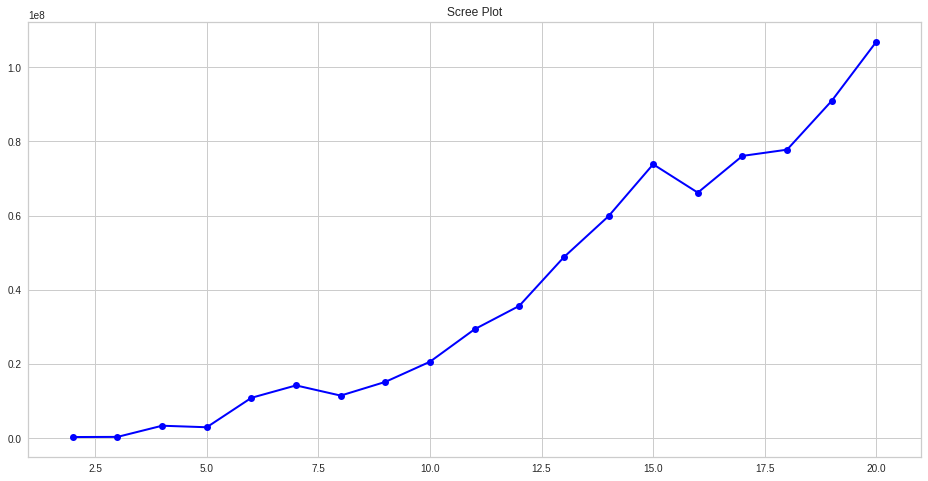

In [ ]:
## Scree Plot 

import matplotlib.pyplot as plt
import numpy as np

x = []

for i in range(2,21):
    x.append(i)


plt.figure(figsize=(16,8))
plt.plot(x, Within, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlim((1,21))
plt.show()


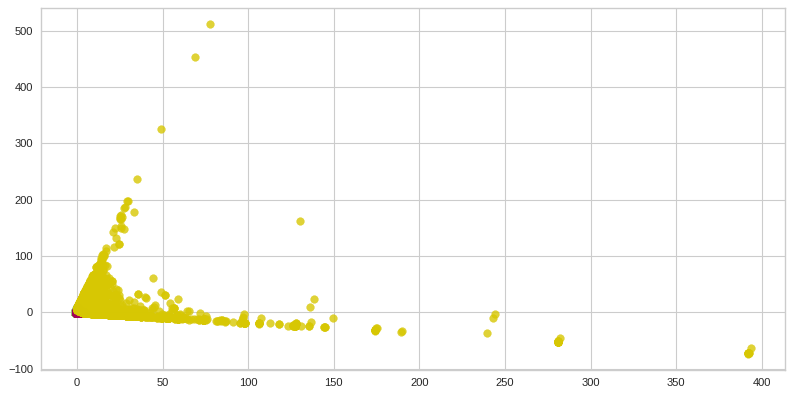

In [ ]:


plt.figure(figsize = (12, 6), dpi = 80)

u_labels = np.unique(labels[3])

for i in u_labels:

    plt.scatter(df_c[labels[3] == i , 0] , df_c[labels[3] == i , 1] , alpha=0.8)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
df_c=df_c.to_numpy()

In [ ]:

index = get_index(df_c,10)

    # now we have the centroids
centroids = df_c[index, :]

In [ ]:
np.argmin(cdist(XA=df_c, XB=centroids, metric= 'euclidean'),axis=1)

array([8, 1, 3, ..., 8, 4, 3])

We Used the k_means ++ from the scikit-learn library

Inside the `KElbowVisualizer` method there are three different metric to evaluate the number of clusters:

*   distortion
*   calinski_harabasz
*   silhouette





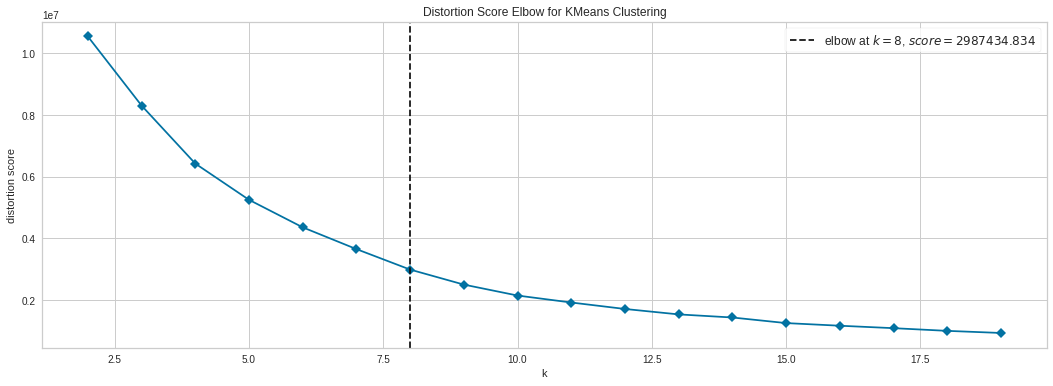

In [ ]:
plt.figure(figsize = (18, 6))
model = KMeans(init = 'k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = 'distortion', timings = False)
visualizer.fit(df_c)
visualizer.show()

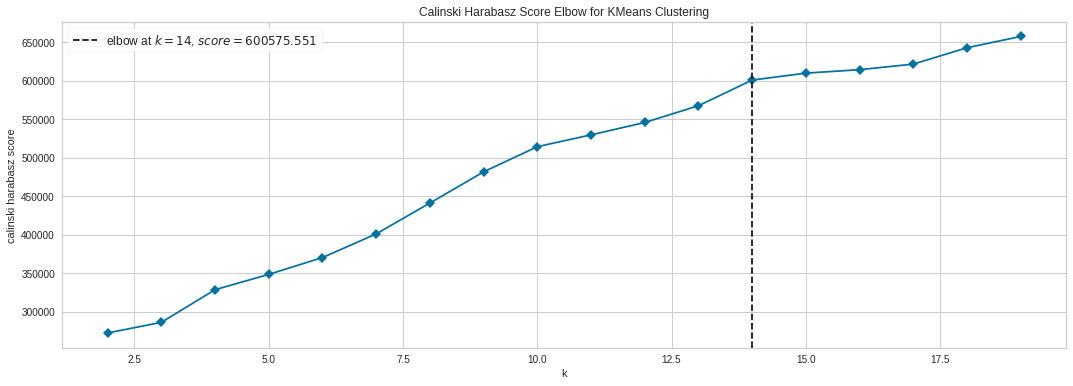

In [ ]:
plt.figure(figsize = (18, 6))
model = KMeans(init = 'k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = 'calinski_harabasz', timings = False)
visualizer.fit(df_c)
visualizer.show()

In [ ]:
plt.figure(figsize = (18, 6))
model = KMeans(init = 'k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = 'silhouette', timings = False)
visualizer.fit(df_c)
visualizer.show()

KeyboardInterrupt: ignored

<Figure size 1296x432 with 0 Axes>